In [1]:
import os
import datetime
from pathlib import Path
import numpy as np
import xarray as xr
import pandas as pd
import glob

import seaborn as sns
#import cmocean as cm            # really nice colorbars
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import stats

#import PyCO2SYS as pyco2

# Make SOCAT mask

In [2]:
# open socat dataset
ds_socat = xr.open_dataset('/data/artemis/observations/SOCAT/originals/SOCATv2022_tracks_gridded_monthly.nc')

In [3]:
ds_socat

<xarray.Dataset>
Dimensions:                (xlon: 360, ylat: 180, tmnth: 624, bnds: 2)
Coordinates:
  * xlon                   (xlon) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
  * ylat                   (ylat) float64 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * tmnth                  (tmnth) datetime64[ns] 1970-01-16T12:00:00 ... 202...
Dimensions without coordinates: bnds
Data variables: (12/25)
    tmnth_bnds             (tmnth, bnds) datetime64[ns] ...
    count_ncruise          (tmnth, ylat, xlon) float64 ...
    fco2_count_nobs        (tmnth, ylat, xlon) float64 ...
    fco2_ave_weighted      (tmnth, ylat, xlon) float32 ...
    fco2_ave_unwtd         (tmnth, ylat, xlon) float32 ...
    fco2_min_unwtd         (tmnth, ylat, xlon) float32 ...
    ...                     ...
    salinity_min_unwtd     (tmnth, ylat, xlon) float32 ...
    salinity_max_unwtd     (tmnth, ylat, xlon) float32 ...
    salinity_std_weighted  (tmnth, ylat, xlon) float32 ...
    salinity_std_unwtd     (tmnth, ylat, xlon) float32 ...
    lat_offset_unwtd       (tmnth, ylat, xlon) float32 ...
    lon_offset_unwtd       (tmnth, ylat, xlon) float32 ...
Attributes:
    history:      PyFerret V7.63 (optimized) 31-May-22
    Conventions:  CF-1.6
    SOCAT_Notes:  SOCAT gridded v2022 26-May-2022
    title:        SOCAT gridded v2022 Monthly 1x1 degree gridded dataset
    summary:      Surface Ocean Carbon Atlas (SOCAT) Gridded (binned) SOCAT o...
    references:   http://www.socat.info/
    caution:      NO INTERPOLATION WAS PERFORMED. SIGNIFICANT BIASES ARE PRES...

In [4]:
# select correct version of SOCAT and year range
da = ds_socat['fco2_ave_unwtd'].sel(tmnth=slice('1982', '2021'))

In [5]:
da

<xarray.DataArray 'fco2_ave_unwtd' (tmnth: 480, ylat: 180, xlon: 360)>
[31104000 values with dtype=float32]
Coordinates:
  * xlon     (xlon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * ylat     (ylat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * tmnth    (tmnth) datetime64[ns] 1982-01-16T12:00:00 ... 2021-12-16T12:00:00
Attributes:
    long_name:  fCO2 mean - unweighted all obs
    units:      uatm
    history:    From SOCAT_ABCD_data_for_gridding
    summary:    Arithmetic mean of all fco2 recomputed values found in the gr...

In [6]:
# rename variable names 
da = da.to_dataset().rename({'tmnth': 'time', 'fco2_ave_unwtd': 'socat_mask'}) #"xlon":"lon", "ylat": "lat",

In [7]:
#check data
da

<xarray.Dataset>
Dimensions:     (xlon: 360, ylat: 180, time: 480)
Coordinates:
  * xlon        (xlon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * ylat        (ylat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * time        (time) datetime64[ns] 1982-01-16T12:00:00 ... 2021-12-16T12:0...
Data variables:
    socat_mask  (time, ylat, xlon) float32 ...

In [8]:
#if there are datapoints i.e. larger than 0 true/false
socat_bool = (da['socat_mask']>0) # true if data exists false otherwise
socat_mask = socat_bool.where(socat_bool) # 1 if data exists nan otherwise

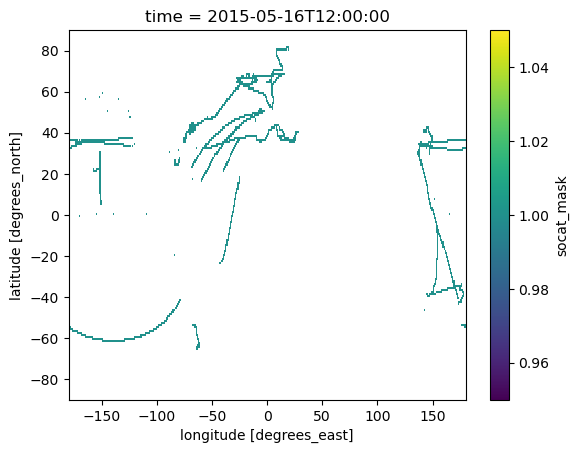

In [9]:
#plot data
socat_mask[400,:,:].plot()

In [10]:
#timedelta64(14,'D') chooses 15th as the start day of the month (14 plus 1 jan etc) 
dates_socat_new = pd.date_range(start="1982-01-01T00:00:00.000000000",
                                end="2021-12-31T00:00:00.000000000",freq="MS")+np.timedelta64(14,'D')

In [11]:
#check that all months start at the 15th
dates_socat_new

DatetimeIndex(['1982-01-15', '1982-02-15', '1982-03-15', '1982-04-15',
               '1982-05-15', '1982-06-15', '1982-07-15', '1982-08-15',
               '1982-09-15', '1982-10-15',
               ...
               '2021-03-15', '2021-04-15', '2021-05-15', '2021-06-15',
               '2021-07-15', '2021-08-15', '2021-09-15', '2021-10-15',
               '2021-11-15', '2021-12-15'],
              dtype='datetime64[ns]', length=480, freq=None)

In [12]:
# overwrite a the dimension of time in the dataarray
#so that for time, use the ones from dates_socat_new in the socat_mask
socat_mask['time'] = dates_socat_new

In [13]:
#socat_mask.head()

## Group normally changes lon to 0 to 360, if decide to do, sample code below

In [14]:
#note here that the longitude is -180 to 180.
#For testbed need 0-->360 longitude

In [15]:
#lon1 = socat_mask.lon
#lon2 = np.where(lon1 <0, lon1+360, lon1)
#socat_mask.coords['lon'] = (lon2)
#socat_mask = socat_mask.sortby(socat_mask.lon)

In [16]:
#print(socat_mask.lon)

In [17]:
#plot data
#socat_mask[400,:,:].plot()

In [18]:
socat_mask

<xarray.DataArray 'socat_mask' (time: 480, ylat: 180, xlon: 360)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * xlon     (xlon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * ylat     (ylat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * time     (time) datetime64[ns] 1982-01-15 1982-02-15 ... 2021-12-15

In [19]:
final_mask = xr.Dataset(
    data_vars={
        'socat_mask':    (('time', 'ylat', 'xlon'), socat_mask.values),
    },
    coords={
        'xlon': socat_mask.xlon,
        'ylat': socat_mask.ylat,
        'time': socat_mask.time
    }
)

final_mask

<xarray.Dataset>
Dimensions:     (time: 480, ylat: 180, xlon: 360)
Coordinates:
  * xlon        (xlon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * ylat        (ylat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * time        (time) datetime64[ns] 1982-01-15 1982-02-15 ... 2021-12-15
Data variables:
    socat_mask  (time, ylat, xlon) float64 nan nan nan nan ... nan nan nan nan

### Make sure have either 1 or nan everywhere

In [20]:
print(final_mask)

<xarray.Dataset>
Dimensions:     (time: 480, ylat: 180, xlon: 360)
Coordinates:
  * xlon        (xlon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * ylat        (ylat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * time        (time) datetime64[ns] 1982-01-15 1982-02-15 ... 2021-12-15
Data variables:
    socat_mask  (time, ylat, xlon) float64 nan nan nan nan ... nan nan nan nan


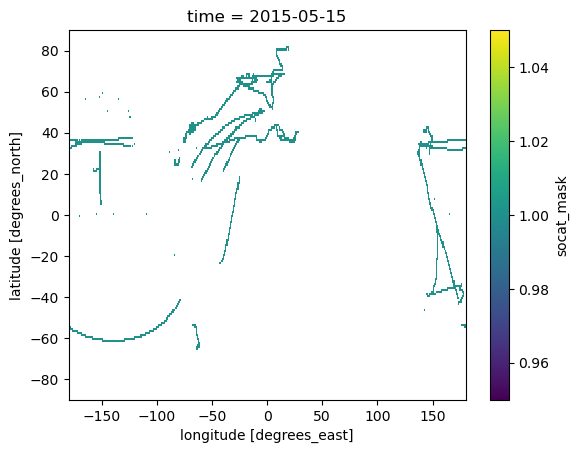

In [21]:
final_mask.socat_mask[400,:,:].plot() #all either NAN or 1

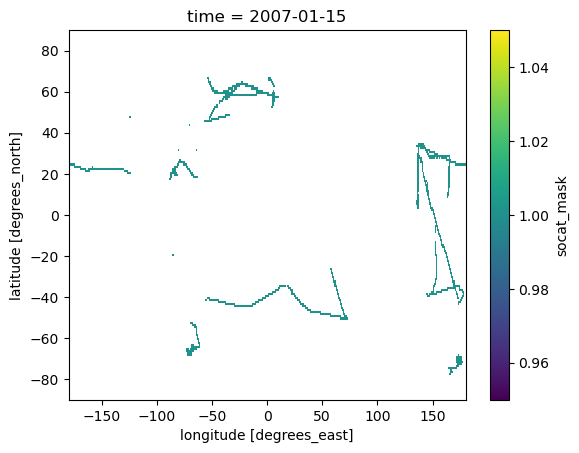

In [22]:
final_mask.socat_mask[300,:,:].plot() #all either NAN or 1

## Create network mask

- This masks out regions in the NCEP land-sea mask (https://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.surface.html) to define the open ocean. 
- Additional regions removed include:
    - Arctic Ocean : defined as North of 79N
    - Hudson Bay
    - Caspian Sea, Black Sea, Mediterranean Sea, Baltic Sea, Java Sea, Red Sea

In [23]:
### Load obs directory
dir_obs = '/local/data/artemis/observations'
    
### Loads grids
# land-sea mask
# land=0, sea=1
ds_lsmask = xr.open_dataset(f'{dir_obs}/masks/originals/lsmask.nc').sortby('lat').squeeze().drop('time')
ds_lsmask = ds_lsmask.rename({'lat': 'ylat', 'lon': 'xlon'})
ds_lsmask = ds_lsmask.assign_coords(xlon=(((ds_lsmask.xlon+180)%360)-180)) # wraps from 0 to 360 to -180 to 180
ds_lsmask = ds_lsmask.sortby(ds_lsmask.xlon) 
data = ds_lsmask['mask'].where(ds_lsmask['mask']==1)
    
### Define Latitude and Longitude
lon = ds_lsmask['xlon']
lat = ds_lsmask['ylat']
    
### Remove Arctic
data = data.where(~((lat>79)))
data = data.where(~((lat>67) & (lat<80) & (lon>20) & (lon<180)))
data = data.where(~((lat>67) & (lat<80) & (lon>-180) & (lon<-100)))

### Remove Caspian Sea, Black Sea, Mediterranean Sea, and Baltic Sea
data = data.where(~((lat>24) & (lat<70) & (lon>14) & (lon<70)))
    
### Remove Hudson Bay
data = data.where(~((lat>50) & (lat<70) & (lon>-100) & (lon<-70)))
data = data.where(~((lat>70) & (lat<80) & (lon>-130) & (lon<-80)))
    
### Remove Red sea
data = data.where(~((lat>10) & (lat<25) & (lon>10) & (lon<45)))
data = data.where(~((lat>20) & (lat<50) & (lon>0) & (lon<20)))

data

<xarray.DataArray 'mask' (ylat: 180, xlon: 360)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * ylat     (ylat) float32 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * xlon     (xlon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Attributes:
    long_name:    Land Sea Mask
    valid_range:  [0 1]
    units:        none
    dataset:      NOAA Optimum Interpolation (OI) SST V2
    var_desc:     Land-sea mask
    level_desc:   Surface
    statistic:    Other

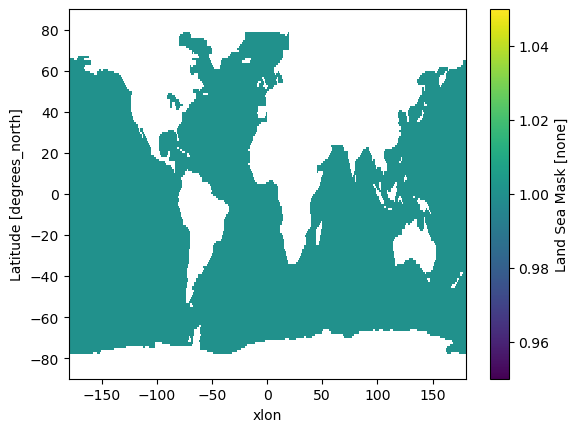

In [24]:
data.plot()

In [25]:
data

<xarray.DataArray 'mask' (ylat: 180, xlon: 360)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * ylat     (ylat) float32 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * xlon     (xlon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Attributes:
    long_name:    Land Sea Mask
    valid_range:  [0 1]
    units:        none
    dataset:      NOAA Optimum Interpolation (OI) SST V2
    var_desc:     Land-sea mask
    level_desc:   Surface
    statistic:    Other

In [26]:
net_mask = np.tile(data.to_dataframe()['mask'].to_numpy(), len(dates_socat_new))

In [27]:
net_mask = np.reshape(np.ravel(net_mask), (480, 180, 360))

In [28]:
final_mask['net_mask'] = final_mask['socat_mask']
final_mask['net_mask'].values = net_mask

In [29]:
final_mask

<xarray.Dataset>
Dimensions:     (time: 480, ylat: 180, xlon: 360)
Coordinates:
  * xlon        (xlon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * ylat        (ylat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * time        (time) datetime64[ns] 1982-01-15 1982-02-15 ... 2021-12-15
Data variables:
    socat_mask  (time, ylat, xlon) float64 nan nan nan nan ... nan nan nan nan
    net_mask    (time, ylat, xlon) float32 nan nan nan nan ... nan nan nan nan

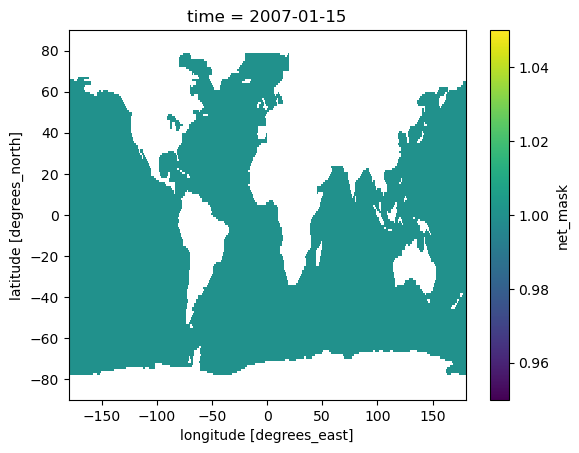

In [30]:
final_mask['net_mask'][300,:,:].plot()

# Save to netcdf

In [33]:
#Save Xarray dataset to an netcdf output file, add attributes

final_mask.attrs['description'] = "Masks created by raw_data/create_mask.ipynb"
final_mask.attrs['Date'] = str(datetime.datetime.now())
final_mask.attrs['Created By'] = "Julia Simpson"
final_mask['socat_mask'].attrs['description'] = "SOCATv2022 mask"
final_mask['net_mask'].attrs['description'] = "Open ocean without Arctic, Hudson Bay, and the following seas: Caspian Sea, Black Sea, Mediterranean Sea, Baltic Sea, Java Sea, Red Sea"

In [34]:
final_mask

<xarray.Dataset>
Dimensions:     (time: 480, ylat: 180, xlon: 360)
Coordinates:
  * xlon        (xlon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * ylat        (ylat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * time        (time) datetime64[ns] 1982-01-15 1982-02-15 ... 2021-12-15
Data variables:
    socat_mask  (time, ylat, xlon) float64 nan nan nan nan ... nan nan nan nan
    net_mask    (time, ylat, xlon) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    description:  Masks created by raw_data/create_mask.ipynb
    Date:         2022-12-29 12:39:52.997977
    Created By:   Julia Simpson

In [35]:
#Save to netcdf    
final_mask.to_netcdf('/home/julias/MLEE-final-project/raw_data/create_mask.nc') 